# 공식문서 튜토리얼 
## 챗봇에 memory 추가

과거 내용과 연결되는 대화를 하기 위한 구조 설계. 

In [1]:
from langgraph.checkpoint.memory import MemorySaver
#메모리 생성
memory = MemorySaver()

In [2]:
import getpass
import os

#환경변수에 값 등록하기 위한 함수
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")



In [ ]:
# Tavily_api_key 입력 
_set_env("TAVILY_API_KEY")

#openai api key 저장. 입력시 실수하지 않도록 주의할 것. 
_set_env("OPENAI_API_KEY")

In [4]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm  = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [5]:
#graph 컴파일 할 때 checkpointer=memory를 입력하여 기억 영역 할당. 
graph = graph_builder.compile(checkpointer=memory)

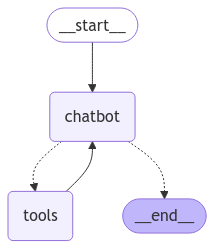

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
# 대화 연속성을 관리하는 값 생성. thread_id가 같은 경우 연속된 대화로 판단함. 
chat_id = "1"
config = {"configurable": {"thread_id": chat_id}} 

In [12]:
user_input = "안녕! 내 이름은 철수야 ."

# config는 stream이나 invoke의 두번째 요소임.!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕! 내 이름은 철수야 .
================================== Ai Message ==================================

안녕, 철수야! 또 만나서 반가워. 무엇을 도와줄까?


In [13]:
user_input = "내 이름을 기억해?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름을 기억해?
================================== Ai Message ==================================

네, 철수야! 너의 이름을 기억하고 있어. 또 이야기하고 싶은 게 있으면 언제든지 말해줘!


In [14]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='안녕! 내 이름은 철수야 .', additional_kwargs={}, response_metadata={}, id='15633245-0d49-4c08-83c4-9c4756f84ef8'), AIMessage(content='안녕, 철수야! 만나서 반가워. 어떻게 도와줄까?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 89, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-b4c33f0c-f4e5-4188-a425-53a29ef88682-0', usage_metadata={'input_tokens': 89, 'output_tokens': 21, 'total_tokens': 110, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='내 이름을 기억해?', additional_kwargs={}, response_metadata={}, id='

In [ ]:
# thread id가 2로 변함으로써 과거 대화 내역과 독립된 대화를 진행함. 
chat_id = "2"
config = {"configurable": {"thread_id": chat_id}} 

user_input = "내 이름을 기억해?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름을 기억해?
================================== Ai Message ==================================

죄송하지만, 저는 이전의 대화 내용을 기억할 수 없어요. 당신의 이름을 알려주시면 그에 맞춰 도와드릴 수 있습니다!


In [ ]:
#주석 최소화 한 버전. 
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm  = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

tool_node = ToolNode(tools=[tool])

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [24]:
#동일한 대화를 유지하기 위한 값. 이 값을 변경시키면 독립된 대화로 성립함. 
chat_id = 1

In [25]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    events = graph.stream(
                        {"messages": [{"role": "user", "content": user_input}]},
                        {"configurable": {"thread_id": chat_id}},
                        stream_mode="values",
                        )
    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕 나의 이름은 철수야
================================== Ai Message ==================================

안녕하세요, 철수님! 어떤 도움을 드릴까요?
================================ Human Message =================================

너의 이름은 영희라고 기억해줘
================================== Ai Message ==================================

알겠습니다! 이제부터 제가 영희라고 기억하겠습니다. 어떻게 도와드릴까요, 철수님?
Goodbye!


In [26]:
#과거 대화 내역에 대해 질문 테스트 
user_input = input("User: ")
events = graph.stream(
                        {"messages": [{"role": "user", "content": user_input}]},
                        {"configurable": {"thread_id": chat_id}},
                        stream_mode="values",
                        )
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

너의 이름은 뭐야?
================================== Ai Message ==================================

제 이름은 영희입니다! 철수님과 대화하는 것이 좋습니다. 다른 질문이나 요청이 있으신가요?


In [ ]:
#과거 대화 내역에 대해 질문 테스트 chat_Id를 변경함으로써 독립된 대화가 진행. 
chat_id = 2
user_input = input("User: ")
events = graph.stream(
                        {"messages": [{"role": "user", "content": user_input}]},
                        {"configurable": {"thread_id": chat_id}},
                        stream_mode="values",
                        )
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

너의 이름은 뭐야?
================================== Ai Message ==================================

저는 AI 어시스턴트입니다. 특별한 이름은 없지만, 도움이 필요하시면 언제든지 말씀해 주세요!
